## Fuzzy C-Means

#### CPU PROCESSING

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from fcmeans import FCM as FCM_CPU # For CPU-based FCM
from fuzzy_c_means_cuda import FuzzyCMeans as FCM_GPU  # For GPU-based FCM
import time
import multiprocessing

def calculate_fcm_cost(X, centers, memberships, m=2.0):
    """Calculate the FCM objective function value J(X,U,C)"""
    n_samples = X.shape[0]
    n_clusters = centers.shape[0]
    cost = 0.0
    
    for i in range(n_samples):
        for j in range(n_clusters):
            dist = np.sum((X[i] - centers[j]) ** 2)
            cost += (memberships[i, j] ** m) * dist
            
    return cost


def quantize_image_CMean(image_path, n_clusters=10, use_gpu=False, m=2.0):
    # Load image and convert to array of pixels
    image = Image.open(image_path)
    N, M = image.size
    X = np.asarray(image).reshape((N * M, 3))

    # Normalize data for cost calculation
    X_normalized = X.astype(np.float32) / 255.0

    start_time = time.time()

    if use_gpu == True: #GPU
        fcm = FCM_GPU(n_clusters=n_clusters, max_iter=10, m=m)
        fcm.fit(X)
        quantized_X, memberships = fcm.predict(X)
        transformed_X = quantized_X
        print(f"Converged in {fcm.n_iter_} iterations (GPU)")

    if use_gpu == False: #CPU
        fcm = FCM_CPU(n_clusters=n_clusters, max_iter=10, m=m)
        fcm.fit(X)
        labeled_X = fcm.predict(X)
        transformed_X = fcm.centers[labeled_X]
        centers_normalized = fcm.centers / 255.0

    elapsed_time = time.time() - start_time
    
    if use_gpu == True:
        cost = calculate_fcm_cost(X_normalized, fcm.centroids, memberships)
    else:
        cost = calculate_fcm_cost(X_normalized, centers_normalized, fcm.u)

    print(f"Processing time ({'GPU' if use_gpu else 'CPU'}): {elapsed_time:.2f} seconds")
    print(f"Cost function value: {cost:.2e}")

    # Convert the quantized array back to image format
    quantized_array = transformed_X.astype('uint8').reshape((M, N, 3))
    quantized_image = Image.fromarray(quantized_array)

    # Display original and quantized images side by side
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    ax[0].imshow(image)
    ax[0].set_title("Original Image")
    ax[0].axis("off")
    
    ax[1].imshow(quantized_image)
    ax[1].set_title(f"Quantized Image ({n_clusters} colors, {'GPU' if use_gpu else 'CPU'})")
    ax[1].axis("off")

    plt.suptitle(
        f"Fuzzy C-Means Quantization ({'GPU' if use_gpu else 'CPU'})\n" +
        f"Time: {elapsed_time:.2f}s, Cost: {cost:.2e}", 
        fontsize=12
    )
    
    plt.show()

    return elapsed_time, cost

# Usage
image_path = 'images/bigimage.jpg'

Processing time (CPU): 78.20 seconds
Cost function value: 1.04e+06


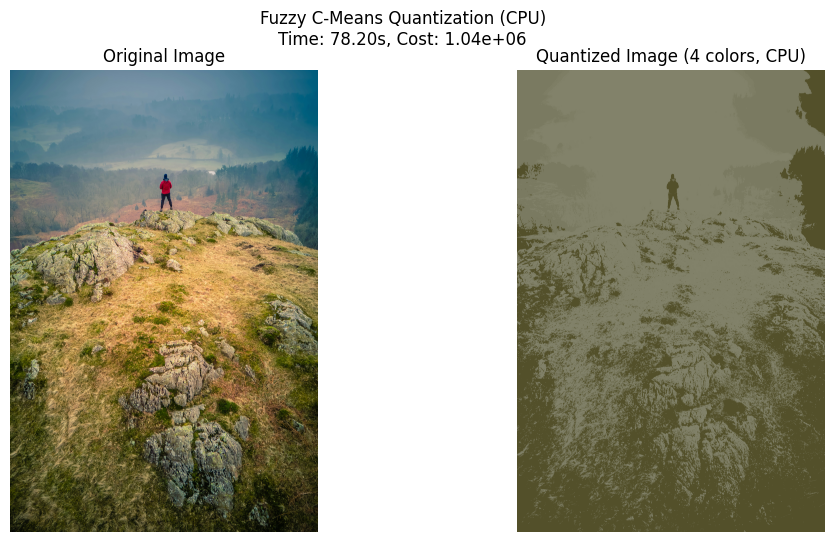


CPU Summary:
Time: 78.20s
Cost: 1.04e+06


In [2]:
cpu_time, cpu_cost = quantize_image_CMean(image_path, n_clusters=4, use_gpu=False, m=2.0)
print("\nCPU Summary:")
print(f"Time: {cpu_time:.2f}s")
print(f"Cost: {cpu_cost:.2e}")

#### GPU PROCESSING (NO SHARED MEMORY)

Highly trade-off, low in complexity but result in a lot of bottleneck! Long processing time

/home/ctl6998/miniconda3/envs/hpc/lib/python3.10/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Finish iteration ${iteration}
Finish iteration ${iteration}
Finish iteration ${iteration}
Finish iteration ${iteration}
Finish iteration ${iteration}
Finish iteration ${iteration}
Finish iteration ${iteration}
Finish iteration ${iteration}
Finish iteration ${iteration}
Finish iteration ${iteration}
Converged in 10 iterations (GPU)
Processing time (GPU): 842.02 seconds
Cost function value: 6.49e+05


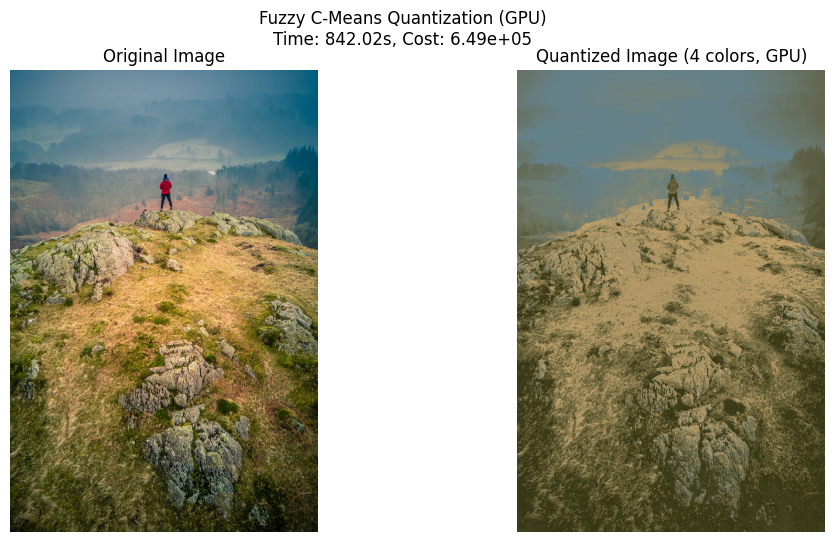


GPU Summary:
Time: 842.02s
Cost: 6.49e+05


In [3]:
# A lot of bottleneck, no shared memory
gpu_time, gpu_cost = quantize_image_CMean(image_path, n_clusters=4, use_gpu=True, m=2.0)
print("\nGPU Summary:")
print(f"Time: {gpu_time:.2f}s")
print(f"Cost: {gpu_cost:.2e}")

#### GPU PPOCESSING WITH SHARED MEMORY

Converged in 10 iterations (GPU)
Processing time GPu: 16.03 seconds


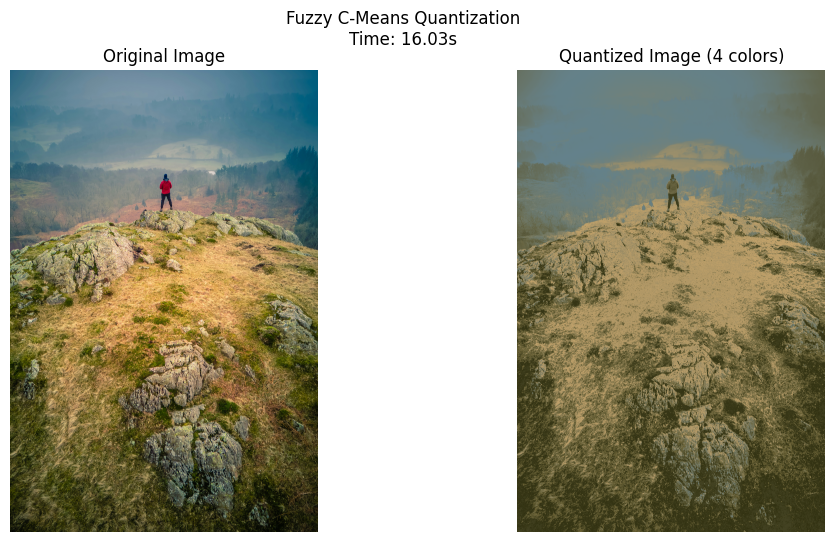

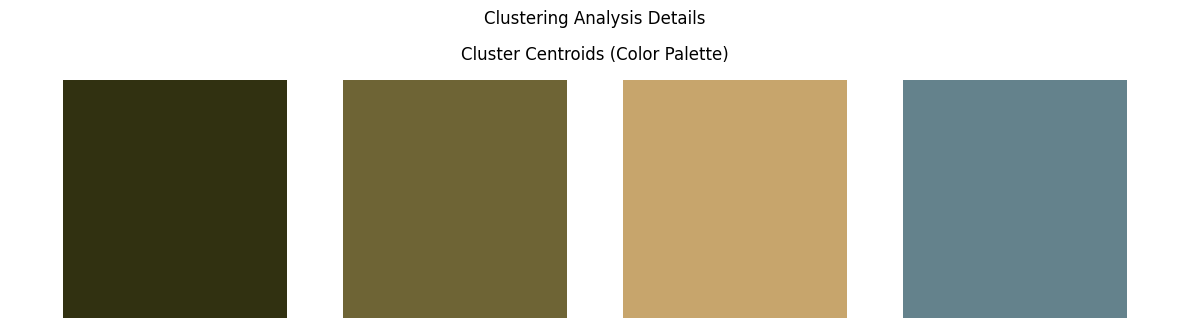

In [3]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from fcmeans import FCM  # For CPU-based FCM
from fuzzy_c_means_shared_cuda import OptimizedFuzzyCMeans  # For GPU-based FCM
import time
import multiprocessing


def quantize_image_CMean(image_path, n_clusters=10, m=2.0):
    # Load image and convert to array of pixels
    image = Image.open(image_path)
    N, M = image.size
    X = np.asarray(image).reshape((N * M, 3))

    # Normalize data for cost calculation
    X_normalized = X.astype(np.float32) / 255.0

    start_time = time.time()

    fcm = OptimizedFuzzyCMeans(n_clusters=n_clusters, max_iter=10, m=m)
    fcm.fit(X)
    quantized_X, memberships = fcm.predict(X)
    transformed_X = quantized_X
    print(f"Converged in {fcm.n_iter_} iterations (GPU)")

    elapsed_time = time.time() - start_time
    print(f"Processing time GPu: {elapsed_time:.2f} seconds")

    # Convert the quantized array back to image format
    quantized_array = transformed_X.astype('uint8').reshape((M, N, 3))
    quantized_image = Image.fromarray(quantized_array)

    # Results
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(image)
    ax[0].set_title("Original Image")
    ax[0].axis("off")
    ax[1].imshow(quantized_image)
    ax[1].set_title(f"Quantized Image ({n_clusters} colors)")
    ax[1].axis("off")
    plt.suptitle(
        f"Fuzzy C-Means Quantization\n" +
        f"Time: {elapsed_time:.2f}s",
        fontsize=12
    )
    plt.show()
    
    # Additional analysis in a new figure
    fig_analysis = plt.figure(figsize=(12, 6))
    
    # Color palette
    plt.subplot(2, 1, 1)
    centroids = fcm.centroids * 255  # Scale back to 0-255 range
    for i, color in enumerate(centroids):
        plt.bar(i, 1, color=color/255)
    plt.title('Cluster Centroids (Color Palette)')
    plt.xticks(range(n_clusters), [f'Cluster {i+1}\nRGB({",".join(map(str, map(int, color)))})' 
                                  for i, color in enumerate(centroids)])
    plt.axis('off')
    
    plt.suptitle('Clustering Analysis Details', fontsize=12)
    plt.tight_layout()
    plt.show()

image_path = 'images/bigimage.jpg'
quantize_image_CMean(image_path, n_clusters=4, m=2.0)